**Import Library**

In [ ]:
import glob
import numpy as np
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip '/content/drive/MyDrive/DL PROJECT/Newfolder.zip'

In [ ]:
# Path to the directory containing the dataset on Google Drive
dataset_path = r'/content/New folder' #path to your dataset
use_colab = True

##**2. Load image from Dataset on Google Drive**

In [ ]:
import os
from tqdm.notebook import tqdm
from pathlib import Path

if use_colab == True:
    path = dataset_path
else:
    path = r"/kaggle/input/dataset/data"
def images_upload(path):
    images=[]
    for root,subfolders,files in os.walk(path):
        for file in tqdm(files):
            filename=root+os.sep+file
            if filename.endswith('jpg') or filename.endswith('png'):
                images.append(filename)
    images = images[0:2000]
    # return  np.random.choice(images, 1000)
    return  np.array(images)
images=images_upload(path)
print(images.shape)
print(images)

  0%|          | 0/81 [00:00<?, ?it/s]

(81,)
['/content/New folder/IDRiD_56.jpg' '/content/New folder/IDRiD_27.jpg'
 '/content/New folder/IDRiD_37.jpg' '/content/New folder/IDRiD_42.jpg'
 '/content/New folder/IDRiD_08.jpg' '/content/New folder/IDRiD_44.jpg'
 '/content/New folder/IDRiD_62.jpg' '/content/New folder/IDRiD_28.jpg'
 '/content/New folder/IDRiD_74.jpg' '/content/New folder/IDRiD_09.jpg'
 '/content/New folder/IDRiD_67.jpg' '/content/New folder/IDRiD_24.jpg'
 '/content/New folder/IDRiD_11.jpg' '/content/New folder/IDRiD_02.jpg'
 '/content/New folder/IDRiD_35.jpg' '/content/New folder/IDRiD_71.jpg'
 '/content/New folder/IDRiD_20.jpg' '/content/New folder/IDRiD_50.jpg'
 '/content/New folder/IDRiD_23.jpg' '/content/New folder/IDRiD_29.jpg'
 '/content/New folder/IDRiD_31.jpg' '/content/New folder/IDRiD_38.jpg'
 '/content/New folder/IDRiD_52.jpg' '/content/New folder/IDRiD_46.jpg'
 '/content/New folder/IDRiD_06.jpg' '/content/New folder/IDRiD_32.jpg'
 '/content/New folder/IDRiD_63.jpg' '/content/New folder/IDRiD_45.jpg'


#**3. Convert data into input and label sets**

In [ ]:
SIZE = 128

In [ ]:
import cv2
from skimage.color import rgb2lab, lab2rgb

def convert_image_labels(images):
    labels=[]
    for i in tqdm(images):
        i = cv2.imread(i)
        i=cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        res_i=cv2.resize(i,(SIZE,SIZE))
        del i
        labels.append(res_i)
    return labels


def convert_image_inputs(images):
    inputs=[]
    for z in tqdm(images):
        z = cv2.imread(z)
        z=cv2.cvtColor(z,  cv2.COLOR_BGR2GRAY)
        res_z=cv2.resize(z,(SIZE,SIZE))
        del z
        inputs.append(res_z)
    return inputs

labels=convert_image_labels(images)
inputs=convert_image_inputs(images)

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
def convert_image_inputs(images):
    labels = []
    for image_path in images:
        img = cv2.imread(image_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            res_img = cv2.resize(img, (SIZE, SIZE))
            labels.append(res_img)
    return labels
labels=convert_image_labels(images)


  0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

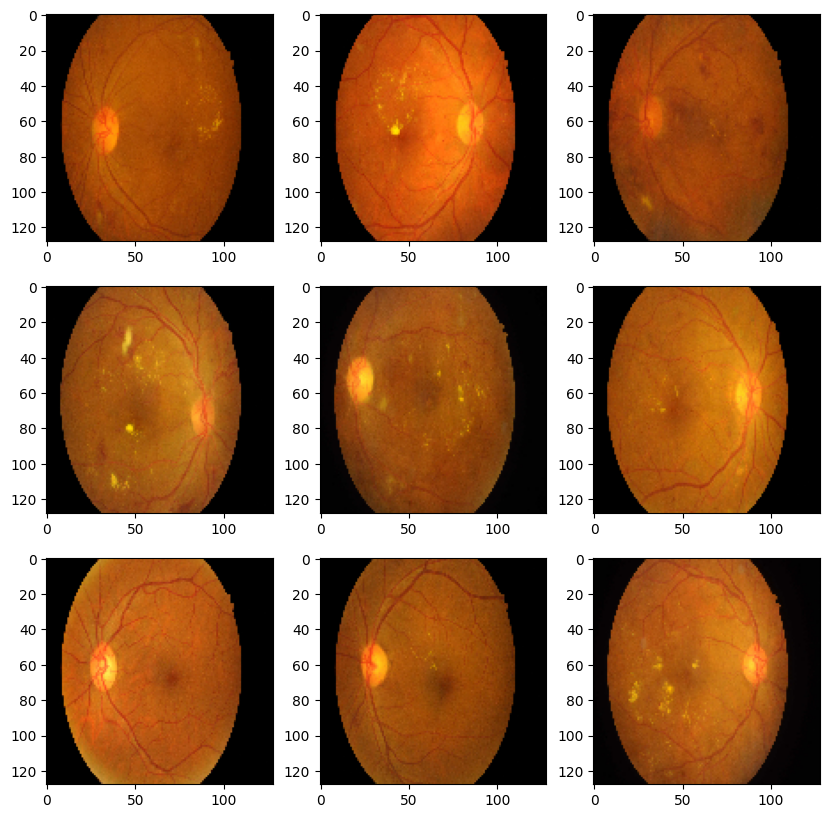

In [ ]:
def show_labels(labels):
    if not labels:
        print("Error: 'labels' is an empty list.")
        return

    plt.figure(figsize=(10, 10))
    for i in range(9):
        idx = np.random.randint(0, len(labels))
        plt.subplot(3, 3, i + 1)
        img = labels[idx]
        plt.imshow(img)

# Assuming labels is a non-empty list
show_labels(labels)


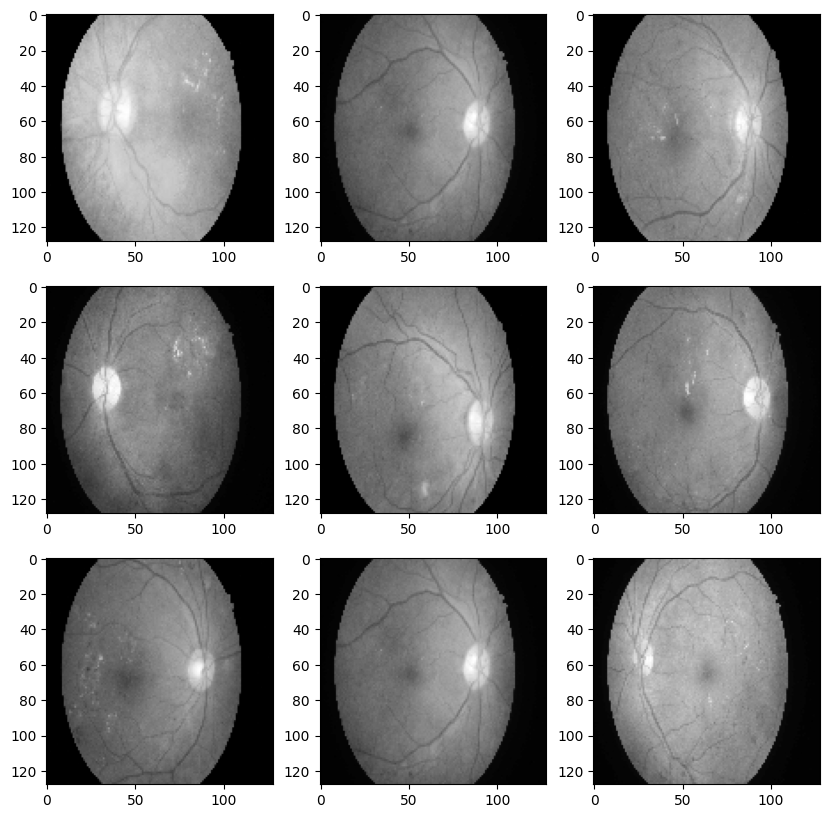

In [ ]:
def show_input(inputs):
    plt.figure(figsize=(10,10))
    for i in range(9):
        idx=np.random.randint(0,len(inputs))
        plt.subplot(3,3,i+1)
        img=inputs[idx]
        plt.imshow(img,cmap='gray')
show_input(inputs)

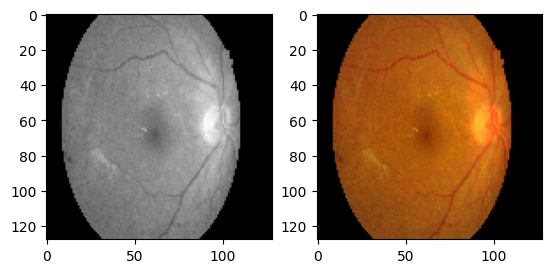

In [ ]:
def images_compare(inputs,labels):
    idx_new=np.random.randint(0,len(labels))
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(inputs[idx_new],cmap='gray')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(labels[idx_new])
    plt.show()
images_compare(inputs,labels)

#**4. Split data to Train/Test set**


In [ ]:
from sklearn.model_selection import train_test_split

def split_data(inputs,labels,test_size=0.2):
    labels=np.array(labels)
    inputs=np.array(inputs)
    x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=test_size)
    return x_train, x_test ,y_train,y_test

In [ ]:
x_train,x_test ,y_train, y_test=split_data(inputs,labels,test_size=0.2)
x_train, x_test=x_train/255.0,x_test/255.0
y_train, y_test=y_train/255.0,y_test/255.0

#**Build model GAN-Unet**

##**1. Build GENERATOR(Unet)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, Conv2DTranspose, Dense,
    Flatten, Dropout, UpSampling2D, Concatenate, ELU,
    Input, LeakyReLU, MaxPooling2D, Reshape, UpSampling2D)
from tensorflow.keras.models import Model
import tensorflow.keras.layers as tfl
from tensorflow.keras.optimizers import Adam

In [ ]:
#GEN 128x128

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Conv2DTranspose, concatenate


def build_generator(inputsize=(128, 128, 1)):
    input = Input(shape=inputsize)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv1')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x1 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv3')(x)
    x = BatchNormalization()(x1)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv4')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv5')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x2 = Conv2D(128, (3, 3), padding="same", strides=(1, 1), kernel_initializer='he_normal', name='Conv6')(x)
    x = BatchNormalization()(x2)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv7')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv8')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x3 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv9')(x)
    x = BatchNormalization()(x3)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv10')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv11')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x4 = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv12')(x)
    x = BatchNormalization()(x4)
    x = LeakyReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool4')(x)

    x = Conv2D(1024, (3, 3), padding="same", name='Conv13')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1024, (3, 3), padding="same", name='Conv14')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1024, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv15')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(512, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = concatenate([x, x4], axis=3)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv16')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv17')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv18')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = concatenate([x, x3], axis=3)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv19')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv20')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv21')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = concatenate([x, x2], axis=3)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv22')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv23')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv24')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = concatenate([x, x1], axis=3)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv25')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv26')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name='Conv27')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    outputs = Conv2D(3, (1, 1), padding="same", activation='tanh', name='Generator_Output')(x)

    generator_model = tf.keras.Model(inputs=input, outputs=outputs)
    generator_model.summary()
    return generator_model

In [ ]:
generator = build_generator(inputsize=(SIZE, SIZE, 1))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 64)         640       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_44 (Ba  (None, 128, 128, 64)         256       ['Conv1[0][0]']               
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_32 (LeakyReLU)  (None, 128, 128, 64)         0         ['batch_normalization_44

##**2. Build DISCRIMINATOR(CNN)**

In [ ]:
def build_discriminator():

    activation = tf.keras.layers.LeakyReLU(alpha=0.2)  

    inputs = Input(shape=(SIZE, SIZE, 3))  

    conv1 = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = activation(conv1)
    conv1 = Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = activation(conv1)
    conv1 = MaxPooling2D()(conv1)

    conv2 = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = activation(conv2)
    conv2 = Conv2D(128, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = activation(conv2)
    conv2 = MaxPooling2D()(conv2)

    conv3 = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = activation(conv3)
    conv3 = Conv2D(256, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = activation(conv3)
    conv3 = MaxPooling2D()(conv3)

    conv4 = Conv2D(512, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = activation(conv4)
    conv4 = Conv2D(512, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = activation(conv4)
    conv4 = MaxPooling2D()(conv4)

    conv5 = Conv2D(1024, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = activation(conv5)
    conv5 = Conv2D(1024, kernel_size=(3, 3), strides=1, padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = activation(conv5)

    fully = Flatten()(conv5)
    fully = Dense(512)(fully)
    fully = BatchNormalization()(fully)
    fully = activation(fully)
    fully = Dense(128)(fully)
    fully = BatchNormalization()(fully)
    fully = activation(fully)
    fully = Dense(32)(fully)
    fully = BatchNormalization()(fully)
    fully = activation(fully)
    fully = Dense(1, activation='sigmoid')(fully)

    model = tf.keras.models.Model(inputs, fully)
    model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    model.summary()
    return model


In [ ]:
discriminator = build_discriminator()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 128, 128, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_75 (Ba  (None, 128, 128, 64)         256       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_63 (LeakyReLU)  multiple                     0         ['batch_normalization_75

##**3. Build a complete GAN model from the two Generator and Discriminator models above**

In [ ]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    input = tf.keras.Input(shape=(SIZE, SIZE, 1))
    generated_image = generator(input)
    validity = discriminator(generated_image)
    gan = tf.keras.Model(inputs=input, outputs=[generated_image, validity])
    gan.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[0.9999, 0.0001], optimizer='adam')
    gan.summary()
    return gan

gan = build_gan(generator, discriminator)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 model_3 (Functional)        (None, 128, 128, 3)       50258499  
                                                                 
 model_4 (Functional)        (None, 1)                 52486529  
                                                                 
Total params: 102745028 (391.94 MB)
Trainable params: 50238915 (191.65 MB)
Non-trainable params: 52506113 (200.29 MB)
_________________________________________________________________


#**Train model**

In [ ]:
import time

def train_gan(generator, discriminator, gan, x_train, y_train, epochs=1000, batch_size=64):
    batch_count = x_train.shape[0] // batch_size
    d_loss_list = []  # Danh sách để lưu giá trị loss của discriminator
    g_loss_list = []  # Danh sách để lưu giá trị loss của generator

    for e in range(epochs):
        start_time = time.time()  # Time start

        for _ in range(batch_count):
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            real_images = y_train[idx]
            gray_images = x_train[idx]

            fake_images = generator.predict(gray_images)

            valid = np.ones((batch_size, 1))
            fake = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(real_images, valid)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            valid = np.ones((batch_size, 1))

            g_loss = gan.train_on_batch(gray_images, [real_images, valid])

        end_time = time.time()  # Time end
        elapsed_time = end_time - start_time

        print(f"Epoch {e}/{epochs}, D Loss: {d_loss[0]}, G Loss: {g_loss[0]}, Time: {elapsed_time:.2f} seconds")

        # Save loss
        d_loss_list.append(d_loss[0])
        g_loss_list.append(g_loss[0])

        # Compute remaining time
        remaining_time = (epochs - e - 1) * elapsed_time
        hours = int(remaining_time // 3600)
        minutes = int((remaining_time % 3600) // 60)
        print(f"Estimated time remaining: {hours} hours {minutes} minutes")

    return d_loss_list, g_loss_list


In [ ]:
num_epochs = 120
d_loss_list, g_loss_list = train_gan(generator, discriminator, gan, x_train, y_train, epochs=num_epochs, batch_size=32)

1/1 [==============================] - 0s 34ms/step
Epoch 0/120, D Loss: 0.7682524025440216, G Loss: 0.30731919407844543, Time: 29.58 seconds
Estimated time remaining: 0 hours 58 minutes
1/1 [==============================] - 0s 20ms/step
Epoch 1/120, D Loss: 0.7165137827396393, G Loss: 0.19591723382472992, Time: 2.74 seconds
Estimated time remaining: 0 hours 5 minutes
1/1 [==============================] - 0s 22ms/step
Epoch 2/120, D Loss: 0.7105077505111694, G Loss: 0.13878291845321655, Time: 2.84 seconds
Estimated time remaining: 0 hours 5 minutes
1/1 [==============================] - 0s 20ms/step
Epoch 3/120, D Loss: 0.6785297989845276, G Loss: 0.1013268306851387, Time: 2.86 seconds
Estimated time remaining: 0 hours 5 minutes
1/1 [==============================] - 0s 30ms/step
Epoch 4/120, D Loss: 0.6832225024700165, G Loss: 0.055745743215084076, Time: 3.12 seconds
Estimated time remaining: 0 hours 5 minutes
1/1 [==============================] - 0s 31ms/step
Epoch 5/120, D Loss: 

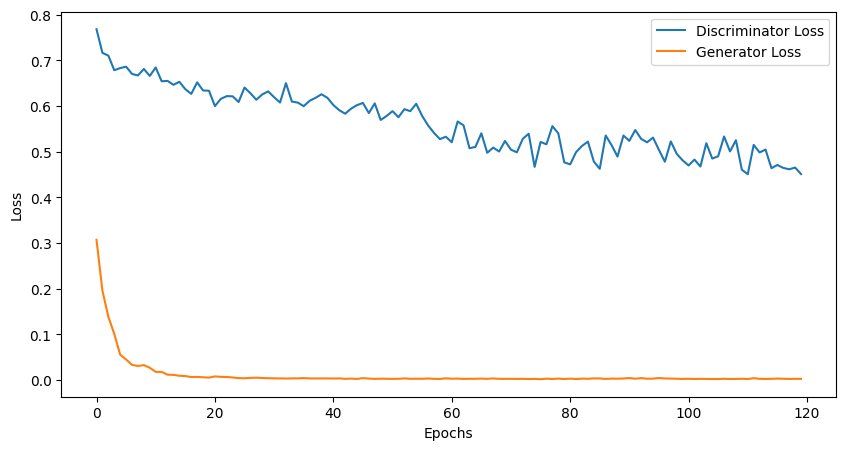

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(d_loss, g_loss, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), d_loss, label="Discriminator Loss")
    plt.plot(range(num_epochs), g_loss, label="Generator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_loss(d_loss_list, g_loss_list, num_epochs)


#**Show results**

In [ ]:
def generate_colored_images(generator, gray_images):
    colored_images = generator.predict(gray_images)
    return colored_images

1/1 [==============================] - 1s 898ms/step


<ipython-input-98-c30cd5e4c07a>:10: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(img1, img2, multichannel=True)
<ipython-input-98-c30cd5e4c07a>:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  return psnr(img1, img2)


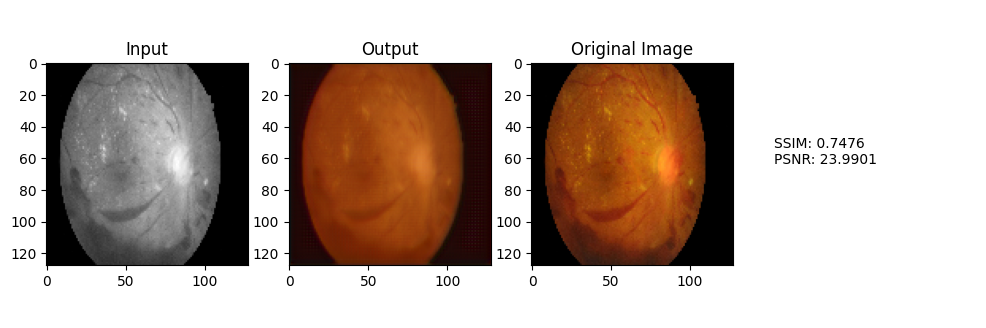

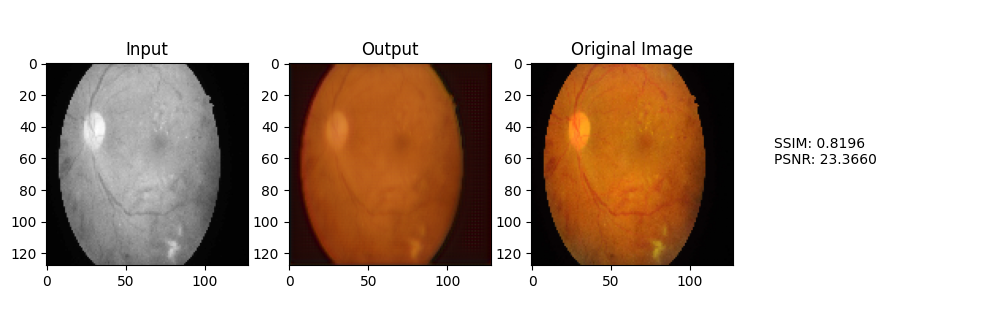

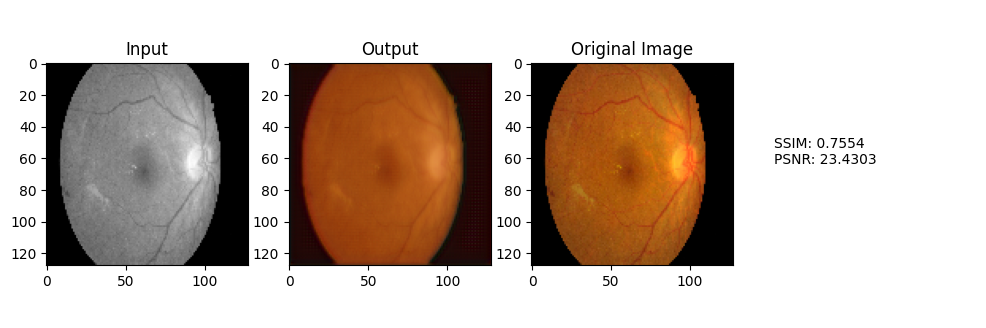

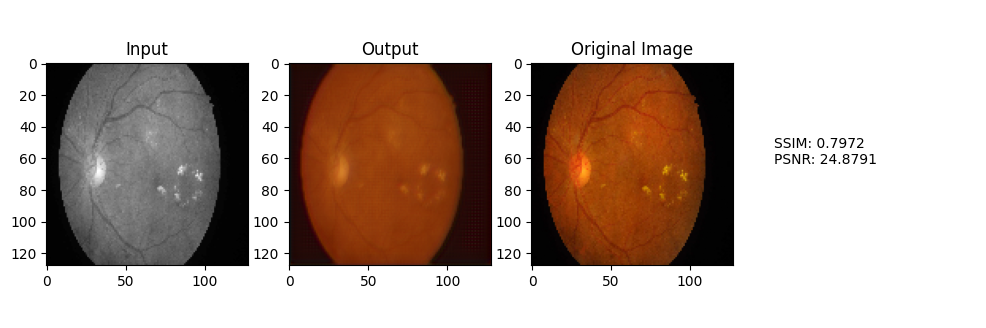

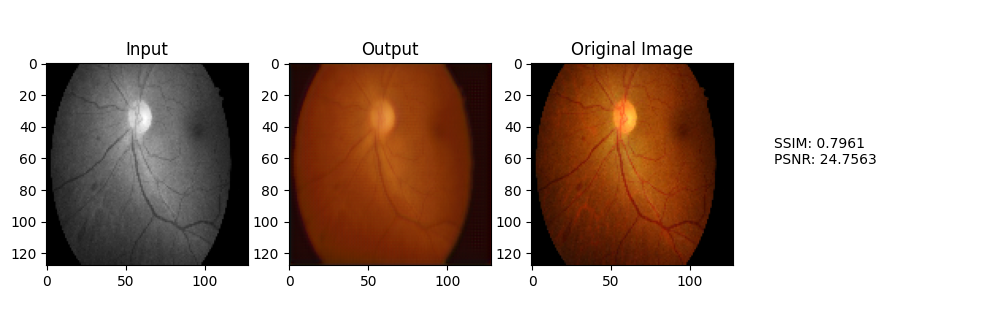

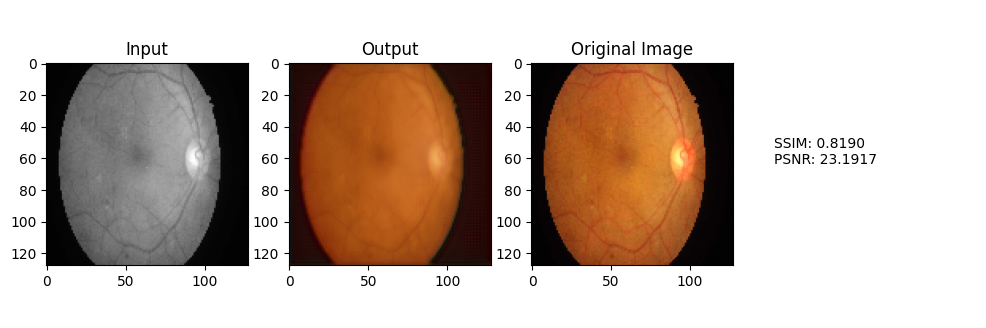

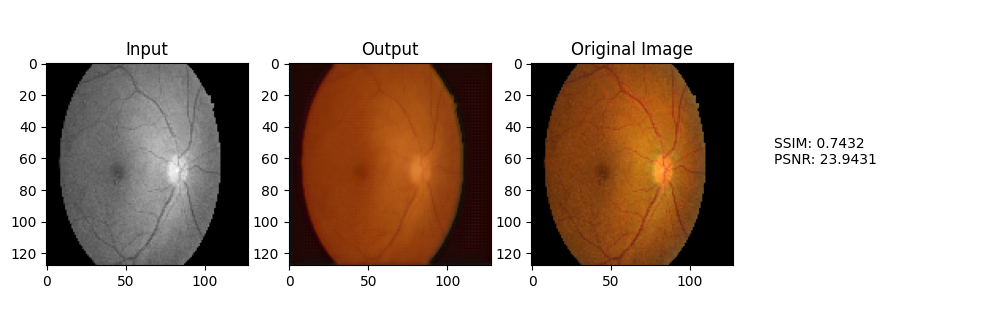

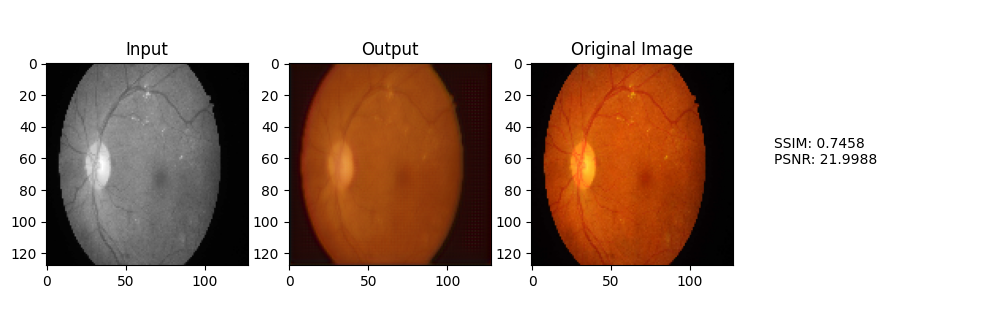

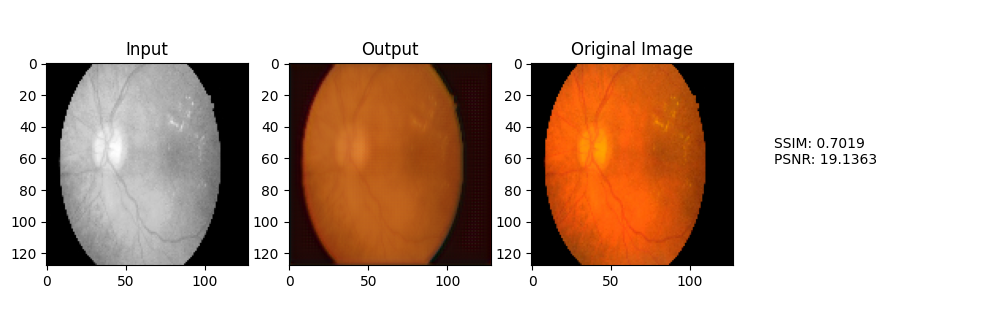

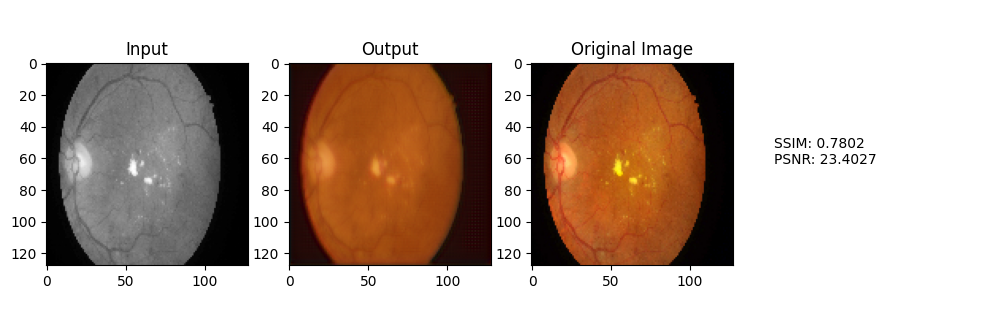

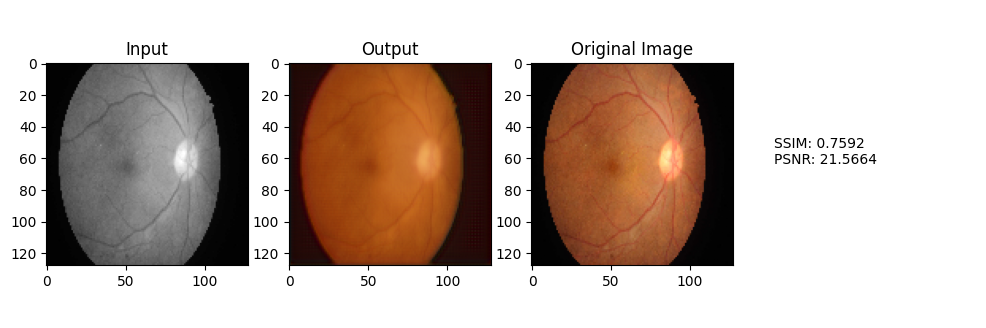

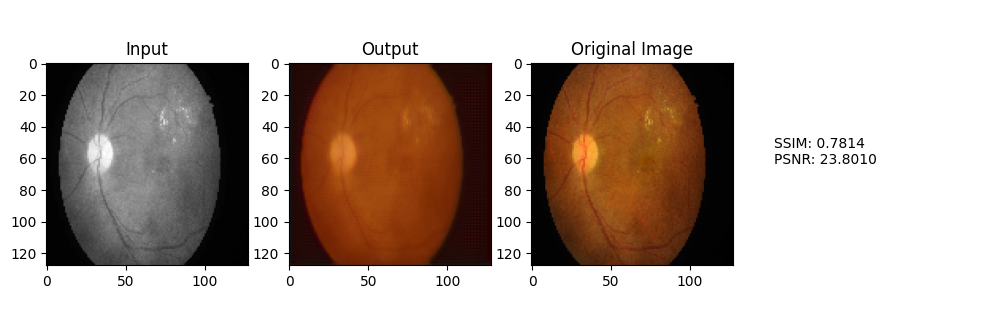

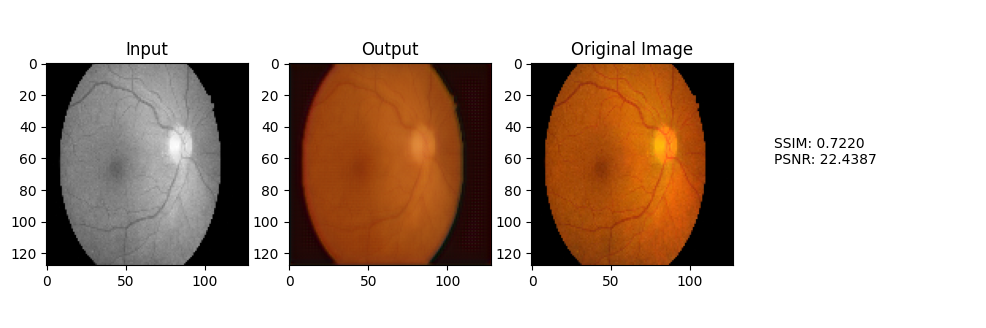

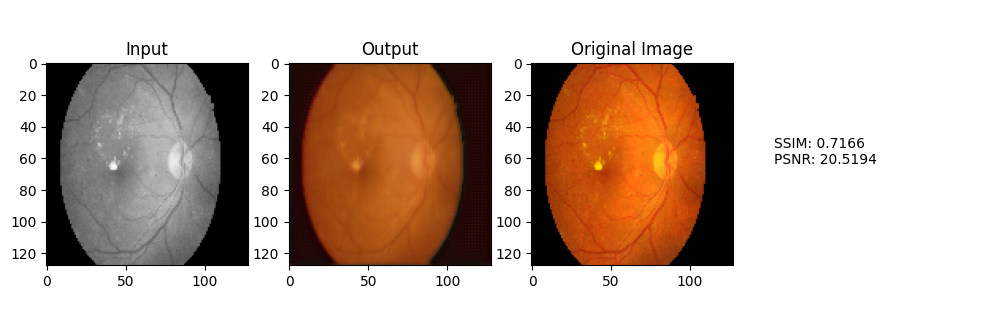

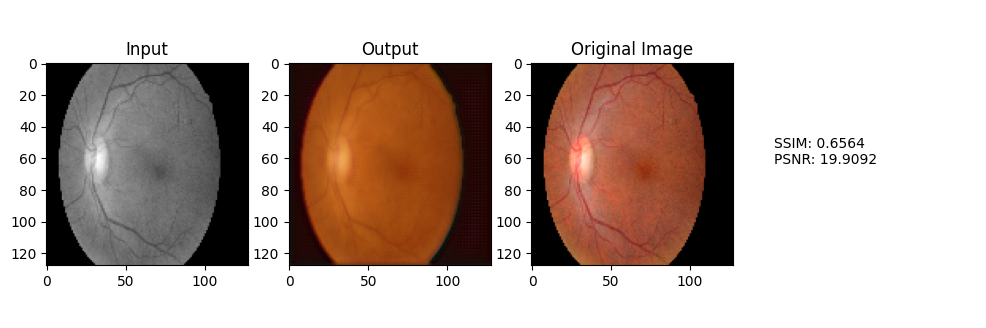

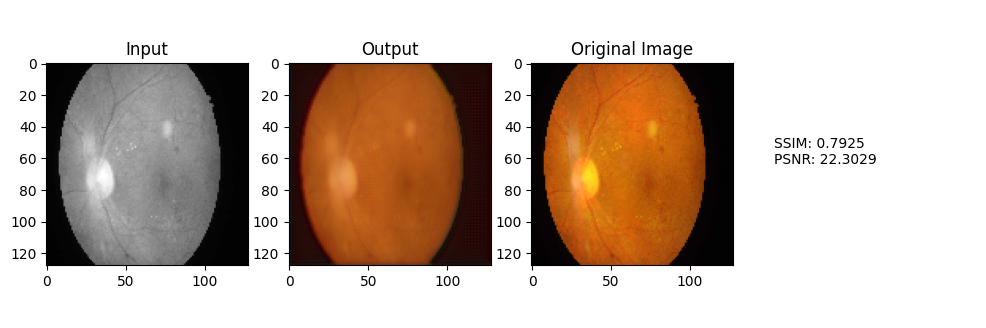

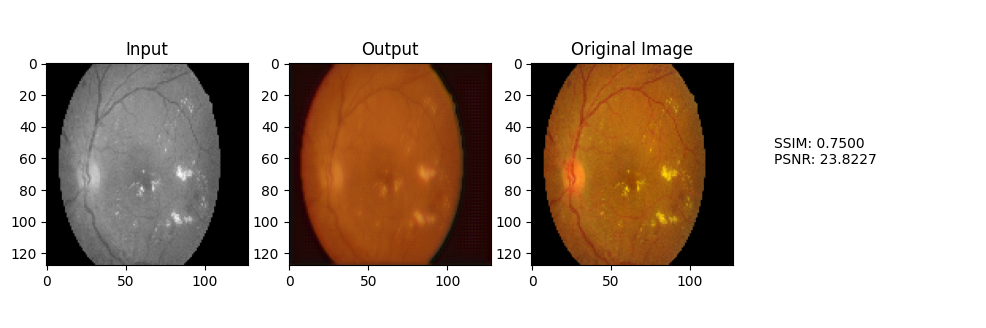

Average SSIM: 0.7579
Average PSNR: 22.7326


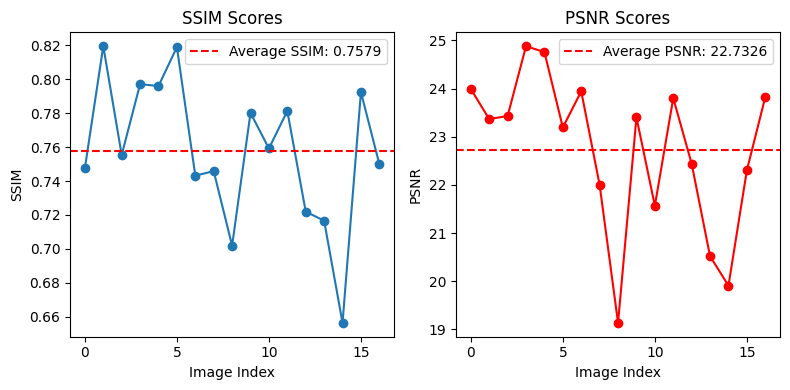

In [ ]:
num_examples_to_generate = len(x_test)
generated_images = generate_colored_images(generator, x_test)
# ...
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Assuming you have functions for SSIM and PSNR
def calculate_ssim(img1, img2):
    return ssim(img1, img2, multichannel=True)

def calculate_psnr(img1, img2):
    return psnr(img1, img2)

def result_compare(y_test, pred, x_test):
    num_samples = len(y_test)

    ssim_scores = []
    psnr_scores = []

    for idx in range(num_samples):
        fig = plt.figure(figsize=(12, 4))
        ax1 = fig.add_subplot(1, 4, 1)
        ax1.imshow(x_test[idx], cmap='gray')
        ax1.set_title('Input')

        ax2 = fig.add_subplot(1, 4, 2)
        ax2.imshow(pred[idx])
        ax2.set_title('Output')

        ax3 = fig.add_subplot(1, 4, 3)
        ax3.imshow(y_test[idx])
        ax3.set_title('Original Image')

        # Calculate and store SSIM and PSNR
        ssim_score = calculate_ssim(y_test[idx], pred[idx])
        psnr_score = calculate_psnr(y_test[idx], pred[idx])
        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)

        # Display SSIM and PSNR values
        ax4 = fig.add_subplot(1, 4, 4)
        ax4.axis('off')
        ax4.text(0, 0.5, f'SSIM: {ssim_score:.4f}\nPSNR: {psnr_score:.4f}', fontsize=10)

        plt.show()

    # Calculate average scores
    avg_ssim = sum(ssim_scores) / num_samples
    avg_psnr = sum(psnr_scores) / num_samples

    print(f'Average SSIM: {avg_ssim:.4f}')
    print(f'Average PSNR: {avg_psnr:.4f}')

    # Plot overall metrics
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(ssim_scores, marker='o')
    plt.axhline(y=avg_ssim, color='r', linestyle='--', label=f'Average SSIM: {avg_ssim:.4f}')
    plt.title('SSIM Scores')
    plt.xlabel('Image Index')
    plt.ylabel('SSIM')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(psnr_scores, marker='o', color='r')
    plt.axhline(y=avg_psnr, color='r', linestyle='--', label=f'Average PSNR: {avg_psnr:.4f}')
    plt.title('PSNR Scores')
    plt.xlabel('Image Index')
    plt.ylabel('PSNR')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming y_test, generated_images, and x_test are defined
result_compare(y_test, generated_images, x_test)


#**Save model to deploy to website**

In [ ]:
from tensorflow.keras.models import load_model

generator.save('/kaggle/working/generator_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# from google.colab import files
# file_path = '/content/generator_model.h5'
# files.download(file_path)